## Setup

In [1]:
%matplotlib notebook
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import tqdm
from ipywidgets import interactive, widgets, Layout

In [2]:
# Constants
cap_value = 1e-6          # Farads
R_init = 500
cutoff_lin = 1. / math.sqrt(2)
cutoff_dB = -20 * math.log10(math.sqrt(2))

## Designing a Low pass Filter from Binary Data
Let's start with an example low pass filter where, given some data about where we want the LED to be lit, we can determine a resistor value manually. In the interactive plot below, we show a transfer function of a low pass filter with its corresponding cutoff frequency. The table below shows the desired behavior (red bars denote that the LED is on for a given frequency while black bars denote that the LED is off); we want to design the circuit such that the LEDs light up in the same way. **Use a slider to find a resistor value and corresponding cutoff frequency such that the predicted lights match the desired lights.**

In [3]:
# Transfer function: evaluates magnitude of given frequencies for a resistor value in the low pass circuit
# Returns in dB (20 * log10(magnitude))
def evaluate_lp_circuit(freqs, R_low):
    return 1. / torch.sqrt(1 + (R_low * cap_value * freqs) ** 2)

<IPython.core.display.Javascript object>


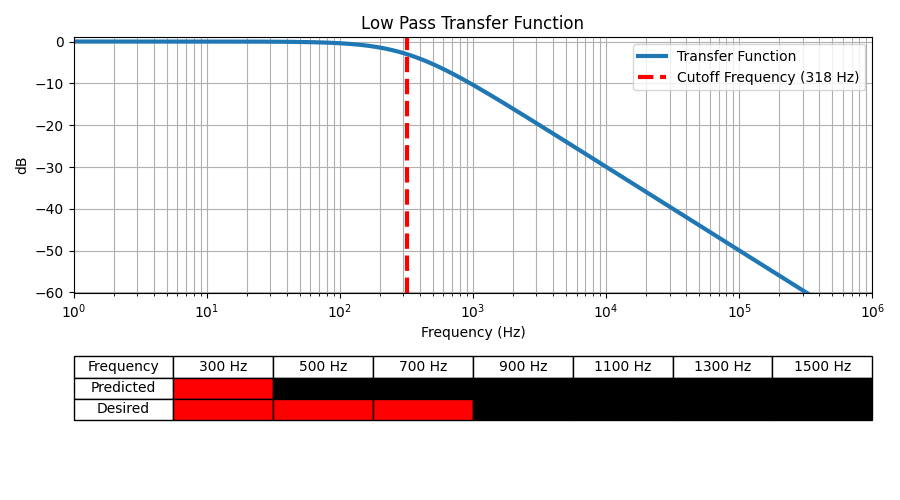

interactive(children=(IntSlider(value=500, description='R', layout=Layout(width='100%'), max=1000, min=1), Out…

In [4]:
# Plot transfer function for a given low pass circuit
fig = plt.figure(figsize=(9, 5))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
mags = 20 * torch.log10(evaluate_lp_circuit(ws, R_init))
cutoff = ws[np.argmax(mags < cutoff_dB)]
tf, = plt.semilogx(ws / (2 * math.pi), mags, linewidth=3)
cut = plt.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
plt.xlim([1, 1e6])
plt.ylim([-60, 1])
plt.title("Low Pass Transfer Function")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.grid(which="both")
leg = plt.legend(["Transfer Function", f"Cutoff Frequency ({1 / (2 * math.pi * R_init * cap_value):.0f} Hz)"])

# Plot table of LED on/off values (predicted and desired)
ws_test = 2 * math.pi * np.linspace(300, 1500, num=7)
table_txt = np.zeros((3, len(ws_test) + 1), dtype="U15")
table_txt[0, :] = ["Frequency"] + [f"{w / (2 * math.pi):.0f} Hz" for w in ws_test]
table_txt[1:, 0] = ["Predicted", "Desired"]
table_colors = np.zeros_like(table_txt, dtype=(np.int32, (3,)))
table_colors[-1, 1:4] = (1, 0, 0)
table_colors[1, 1] = (1, 0, 0)
table_colors[:, :1] = (1, 1, 1)
table_colors[:1, :] = (1, 1, 1)
tab = plt.table(table_txt, table_colors, bbox=[0.0, -0.5, 1.0, 0.25], cellLoc="center")
plt.tight_layout()

# Main update function for interactive plot
def update_lights(R=R_init):
    mags = 20 * torch.log10(evaluate_lp_circuit(ws, R))
    cutoff = ws[np.argmax(mags < cutoff_dB)]
    tf.set_data(ws / (2 * math.pi), mags)
    cut.set_xdata(cutoff / (2 * math.pi))
    for i, w in enumerate(ws_test):
        if w < cutoff:
            tab[(1, i+1)].set_facecolor((1, 0, 0))
        else:
            tab[(1, i+1)].set_facecolor((0, 0, 0))
    leg.get_texts()[1].set_text(f"Cutoff Frequency ({1 / (2 * math.pi * R * cap_value):.0f} Hz)")
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_lights, 
                 R=widgets.IntSlider(value=R_init, min=1, max=1000, step=1, description="R", layout=Layout(width='100%')))
ip

## Designing a Low Pass Filter by Matching Transfer Functions
Now, consider a case where we are instead given a desired transfer function. In this case, we want to find a resistor value for our filter that will yield the same behavior as the desired transfer function. **Use a slider to find a resistor value such that the predicted and desired transfer functions match.**

<IPython.core.display.Javascript object>


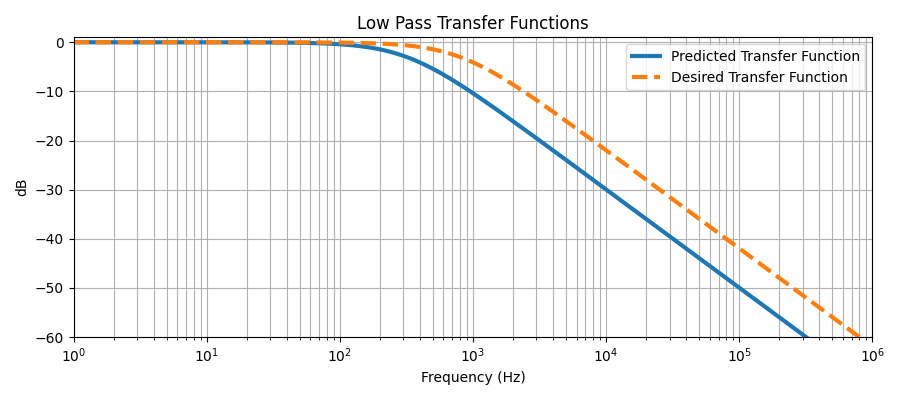

interactive(children=(IntSlider(value=500, description='R', layout=Layout(width='100%'), max=1000, min=1), Out…

In [5]:
# Plot transfer function for a given low pass circuit
fig = plt.figure(figsize=(9, 4))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
mags = 20 * torch.log10(evaluate_lp_circuit(ws, R_init))
R_low_des = 1 / (2 * math.pi * 800 * cap_value)
mags_des = 20 * torch.log10(evaluate_lp_circuit(ws, R_low_des))
tf, = plt.semilogx(ws / (2 * math.pi), mags, linewidth=3)
tf_des, = plt.semilogx(ws / (2 * math.pi), mags_des, linestyle="--", linewidth=3)
plt.xlim([1, 1e6])
plt.ylim([-60, 1])
plt.title("Low Pass Transfer Functions")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.grid(which="both")
leg = plt.legend(["Predicted Transfer Function", "Desired Transfer Function"])
plt.tight_layout()

# Main update function for interactive plot
def update_tfs(R=R_init):
    mags = 20 * torch.log10(evaluate_lp_circuit(ws, R))
    tf.set_data(ws / (2 * math.pi), mags)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_tfs, 
                 R=widgets.IntSlider(value=R_init, min=1, max=1000, step=1, description="R", layout=Layout(width='100%')))
ip

## Learning a Low Pass Filter from Desired Transfer Function Samples
Now, let's assume that we are able to query the desired transfer function directly (i.e., we can play a frequency and record the magnitude of the output). Can we learn the resistor value in the low pass circuit directly from this data?

The code below creates a model of the low pass filter in pytorch, generates training data, and then trains the circuit using mean squared error loss until convergence or the maximum number of training steps are reached.

In [48]:
# PyTorch model of the low pass circuit (for training)
class LowPassCircuit(nn.Module):
    def __init__(self, R=None):
        super().__init__()
        self.R = nn.Parameter(torch.tensor(R, dtype=float) if R is not None else torch.rand(1) * 1000)
        
    def forward(self, freqs):
        return evaluate_lp_circuit(freqs, self.R)
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
def generate_lp_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = evaluate_lp_circuit(rand_ws, R_low_des)
    return rand_ws, labels

# Train a given low pass filter
def train_lp_circuit_tf(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [float(circuit.R.data)]
    grad_values = [np.nan]
    train_data = generate_lp_training_data(dataset_size)
    print(f"Initial Resistor Value: R = {float(circuit.R.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        loss = loss_fn(pred, train_data[1]).mean()
        grad = torch.autograd.grad(loss, circuit.R)
        with torch.no_grad():
            circuit.R -= lr * grad[0]

        R_values.append(float(circuit.R.data))
        grad_values.append(float(grad[0].data))
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R={float(circuit.R.data):.0f}")
        if loss.data < 1e-6 or abs(grad[0].data) < 1e-6:
            break

    print(f"Final Resistor Value: R = {float(circuit.R.data):.0f}")        
    return train_data, R_values, grad_values

These parameters change how quickly or if the training will converge and the final line actually trains the circuit. Try running this to see if the circuit converges to the correct resistor value that you found above!

In [49]:
# Create a circuit, use MSE loss with learning rate of 0.001, batch size 1k and 1k training steps
lr = 1000
dataset_size = 1000
max_training_steps = 10000
circuit = LowPassCircuit()
loss_fn = lambda x, y: (x - y) ** 2
train_data_low_tf, R_values_low_tf, grad_values_low_tf = train_lp_circuit_tf(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Value: R = 537


Training Iter:  36%|█████████████████████████████████████████████████▌                                                                                         | 3565/10000 [00:02<00:03, 1667.90it/s, Loss: 0.004, R=314]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training Iter:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8822/10000 [00:05<00:00, 1627.74it/s, Loss: 0.000, R=201]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
Notebo

The plots below show how the transfer function of the learned circuit evolved during training, the loss surface and the loss from each training point at each iteration, and the gradient at each training iteration. Note that the learned transfer function and resistor value change more slowly when the gradient is small, and more quickly when the gradient is large. Try initializing the circuit with different resistor values (there is an optional argument for the circuit class constructor, if you leave it blank it will be initialized to a random value between 0 and 1000). **How long does the circuit take to converge with different initializations?** Try changing the learning rate. **What values of `lr` cause training to diverge? What value causes the circuit to converge quickly?**

<IPython.core.display.Javascript object>


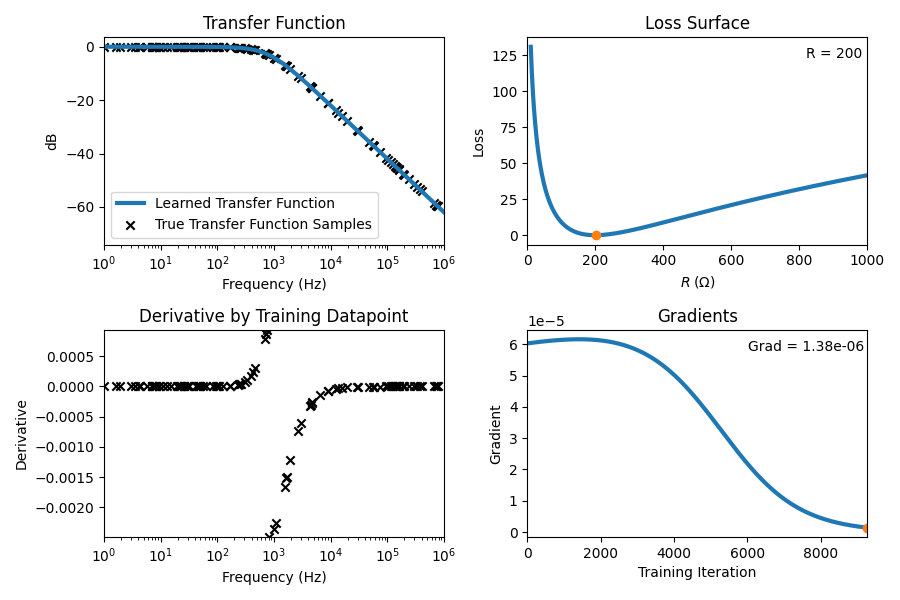

interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=92…

In [52]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
ax1.scatter(train_data_low_tf[0][::subsample] / (2 * math.pi), 20 * torch.log10(train_data_low_tf[1][::subsample]), c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), 20 * torch.log10(evaluate_lp_circuit(ws, R_values_low_tf[0])), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
# ax1.grid(which="both")
ax1.legend(["Learned Transfer Function", "True Transfer Function Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_lp_circuit(train_data_low_tf[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn(eval_vals, train_data_low_tf[1][:, None].expand(eval_vals.shape))
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_low_tf[0], loss_surface_mse[:, int(R_values_low_tf[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_low_tf[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
# data_loss_mags = loss_surface_mse[::subsample, int(R_values_low_tf[0] - 10)].numpy()
# datapoint_loss = ax3.scatter(train_data_low_tf[0][::subsample] / (2 * math.pi), data_loss_mags, marker="x", c="k")
# ax3.set_xscale("log")
# ax3.set_ylabel("Loss")
# ax3.set_xlabel("Frequency (Hz)")
# ax3.set_xlim([1, 1e6])
# ax3.set_title("Loss by Training Datapoint")
cur_circuit = LowPassCircuit(R_values_low_tf[0])
data_losses = loss_fn(cur_circuit(train_data_low_tf[0][::subsample]), (train_data_low_tf[1][::subsample] > cutoff_lin).float())
data_grads = torch.zeros(len(data_losses))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
data_grads_scat = ax3.scatter(train_data_low_tf[0][::subsample] / (2 * math.pi), data_grads, marker="x", c="k")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_low_tf)), grad_values_low_tf, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_low_tf[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_low_tf[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_low_tf)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_tf(t=0):
    learned_tf.set_data(ws / (2 * math.pi), 20 * torch.log10(evaluate_lp_circuit(ws, R_values_low_tf[t])))
    cur_loss.set_data(R_values_low_tf[t], loss_surface_mse[:, int(R_values_low_tf[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_low_tf[t]:.0f}")
    cur_iter.set_data(t, grad_values_low_tf[t])
    cur_grad_label.set_text(f"Grad = {grad_values_low_tf[t]:.2e}")
#     data_loss_mags = loss_surface_mse[::subsample, int(R_values_low_tf[t] - 10)]
#     datapoint_loss.set_offsets(torch.stack((train_data_low_tf[0][::subsample] / (2 * math.pi), data_loss_mags)).T)
    cur_circuit = LowPassCircuit(R_values_low_tf[t])
    data_losses = loss_fn(cur_circuit(train_data_low_tf[0][::subsample]), (train_data_low_tf[1][::subsample] > cutoff_lin).float())
    data_grads = torch.zeros(len(data_losses))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
    data_grads_scat.set_offsets(torch.stack((train_data_low_tf[0][::subsample] / (2 * math.pi), data_grads)).T)
    ax3.set_ylim([data_grads.min(), data_grads.max()])
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_tf, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_low_tf) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Learning a Low Pass Filter from Binary Data
Now, using the same loss function as above, let's try to learn the resistor value using only the binary data we have (LED on the color organ being on or off). **Change the code below to use binary data instead of the transfer function magnitudes that are used above.**

In [53]:
# Train a given low pass filter from binary data
def train_lp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [float(circuit.R.data)]
    grad_values = [np.nan]
    train_data = generate_lp_training_data(dataset_size)
    print(f"Initial Resistor Value: R = {float(circuit.R.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = circuit(train_data[0])
        loss = loss_fn(pred, (train_data[1] > cutoff_lin).float()).mean()
        grad = torch.autograd.grad(loss, circuit.R)
        with torch.no_grad():
            circuit.R -= lr * grad[0]

        R_values.append(float(circuit.R.data))
        grad_values.append(float(grad[0].data))
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R={float(circuit.R.data):.0f}")
        if loss.data < 1e-6 or abs(grad[0].data) < 1e-6:
            break

    print(f"Final Resistor Value: R = {float(circuit.R.data):.0f}")        
    return train_data, R_values, grad_values

In [54]:
# Create a circuit, use MSE loss with learning rate of 200, batch size 1k and max 100k training steps
lr = 200
dataset_size = 1000
max_training_steps = 100000
circuit = LowPassCircuit()
loss_fn = lambda x, y: (x - y) ** 2
train_data_low_bin, R_values_low_bin, grad_values_low_bin = train_lp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Value: R = 502


Training Iter:   4%|█████▎                                                                                                                                    | 3885/100000 [00:02<00:57, 1672.06it/s, Loss: 0.024, R=473]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training Iter:  10%|█████████████▏                                                                                                                            | 9599/100000 [00:05<00:53, 1684.96it/s, Loss: 0.023, R=436]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
Notebo

Final Resistor Value: R = 347


<IPython.core.display.Javascript object>


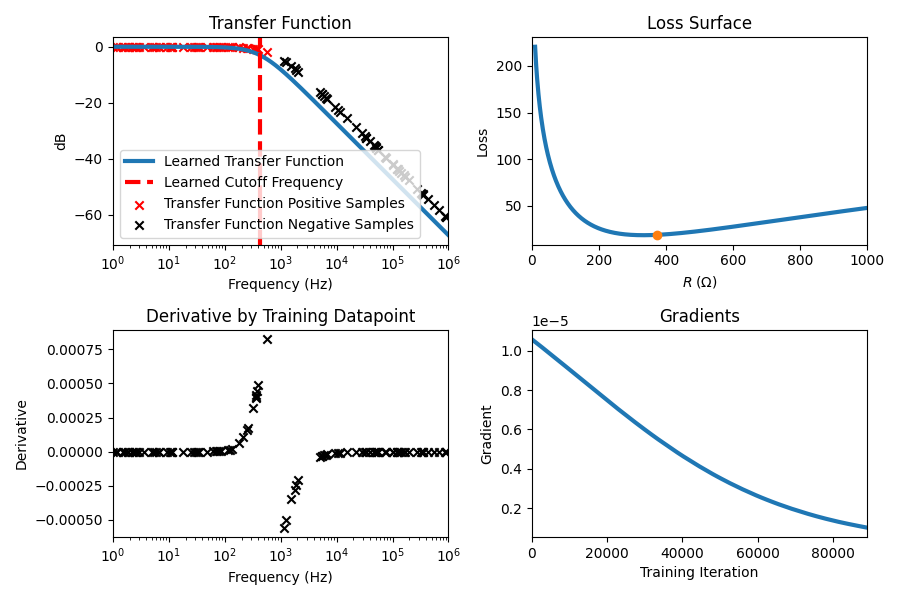

interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=89…

In [46]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_low_bin[1][::subsample] > cutoff_lin
ax1.scatter(train_data_low_bin[0][::subsample][train_data_mask] / (2 * math.pi), 20 * torch.log10(train_data_low_bin[1][::subsample][train_data_mask]), c="r", marker="x")
ax1.scatter(train_data_low_bin[0][::subsample][~train_data_mask] / (2 * math.pi), 20 * torch.log10(train_data_low_bin[1][::subsample][~train_data_mask]), c="k", marker="x")
mags = 20 * torch.log10(evaluate_lp_circuit(ws, R_values_low_bin[0]))
learned_tf, = ax1.semilogx(ws / (2 * math.pi), mags, linewidth=3)
cutoff = ws[np.argmax(mags < cutoff_dB)]
cut = ax1.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
# ax1.grid(which="both")
ax1.legend(["Learned Transfer Function", "Learned Cutoff Frequency", "Transfer Function Positive Samples", "Transfer Function Negative Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_lp_circuit(train_data_low_bin[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn(eval_vals, (train_data_low_bin[1][:, None].expand(eval_vals.shape) > cutoff_lin).float())
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_low_bin[0], loss_surface_mse[:, int(R_values_low_bin[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_low_bin[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
# data_loss_mags = loss_surface_mse[::subsample, int(R_values_low_bin[0] - 10)]
cur_circuit = LowPassCircuit(R_values_low_bin[0])
data_losses = loss_fn(cur_circuit(train_data_low_bin[0][::subsample]), (train_data_low_bin[1][::subsample] > cutoff_lin).float())
data_grads = torch.zeros(len(data_losses))
for i, dl in enumerate(data_losses):
    data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
data_grads_scat = ax3.scatter(train_data_low_bin[0][::subsample] / (2 * math.pi), data_grads, marker="x", c="k")
# datapoint_loss = ax3.scatter(train_data_low_bin[0][::subsample] / (2 * math.pi), data_loss_mags, marker="x", c="k")
ax3.set_xscale("log")
ax3.set_ylabel("Derivative")
ax3.set_xlim([1, 1e6])
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Derivative by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_low_bin)), grad_values_low_bin, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_low_bin[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_low_bin[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_low_bin)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_low_bin(t=0):
    mags = 20 * torch.log10(evaluate_lp_circuit(ws, R_values_low_bin[t]))
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cutoff = ws[np.argmax(mags < cutoff_dB)]
    cut.set_xdata(cutoff / (2 * math.pi))
    cur_loss.set_data(R_values_low_bin[t], loss_surface_mse[:, int(R_values_low_bin[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_low_bin[t]:.0f}")
    cur_iter.set_data(t, grad_values_low_bin[t])
    cur_grad_label.set_text(f"Grad = {grad_values_low_bin[t]:.2e}")
#     data_loss_mags = loss_surface_mse[::subsample, int(R_values_low_bin[t] - 10)]
#     datapoint_loss.set_offsets(torch.stack((train_data_low_bin[0][::subsample] / (2 * math.pi), data_loss_mags)).T)
    cur_circuit = LowPassCircuit(R_values_low_bin[t])
    data_losses = loss_fn(cur_circuit(train_data_low_bin[0][::subsample]), (train_data_low_bin[1][::subsample] > cutoff_lin).float())
    data_grads = torch.zeros(len(data_losses))
    for i, dl in enumerate(data_losses):
        data_grads[i] = torch.autograd.grad(dl, cur_circuit.R, retain_graph=True)[0]
    data_grads_scat.set_offsets(torch.stack((train_data_low_bin[0][::subsample] / (2 * math.pi), data_grads)).T)
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_low_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_low_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Learning a High Pass Filter from Binary Data
Let's use what we learned in the previous parts to also learn our high pass filter from binary data. **Input the high pass filter transfer function into the high pass circuit module below.**

In [9]:
# Transfer function: evaluates magnitude of given frequencies for a resistor value in the high pass circuit
# Returns in dB (20 * log10(magnitude))
def evaluate_hp_circuit(freqs, R_high):
    return 20 * torch.log10((R_high * cap_value * freqs) / torch.sqrt(1 + (R_high * cap_value * freqs) ** 2))

# PyTorch model of the high pass circuit (for training)
class HighPassCircuit(nn.Module):
    def __init__(self, R=None):
        super().__init__()
        self.R = nn.Parameter(torch.tensor(R, dtype=float) if R is not None else torch.rand(1) * 1000)
        
    def forward(self, freqs):
        return evaluate_hp_circuit(freqs, self.R)
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
R_high_des = 1 / (2 * math.pi * 5000 * cap_value)
def generate_hp_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = evaluate_hp_circuit(rand_ws, R_high_des)
    return rand_ws, labels

# Train a given low pass filter from binary data
def train_hp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [float(circuit.R.data)]
    grad_values = [np.nan]
    train_data = generate_hp_training_data(dataset_size)
    print(f"Initial Resistor Value: R = {float(circuit.R.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = nn.Sigmoid()(circuit(train_data[0]) - cutoff_dB)
        loss = loss_fn(pred, (train_data[1] > cutoff_dB).float()).mean()
        grad = torch.autograd.grad(loss, circuit.R)
        with torch.no_grad():
            circuit.R -= lr * grad[0]

        R_values.append(float(circuit.R.data))
        grad_values.append(float(grad[0].data))
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R={float(circuit.R.data):.0f}")
        if loss.data < 1e-6 or abs(grad[0].data) < 1e-6:
            break

    print(f"Final Resistor Value: R = {float(circuit.R.data):.0f}")        
    return train_data, R_values, grad_values

In [ ]:
# Create a circuit, use MSE loss with learning rate of 100, dataset size 1k and max 100k training steps
lr = 100
dataset_size = 1000
max_training_steps = 100000
circuit = HighPassCircuit()
loss_fn = lambda x, y: (x - y) ** 2
train_data_high_bin, R_values_high_bin, grad_values_high_bin = train_hp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

In [ ]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_high_bin[1][::subsample] > cutoff_dB
ax1.scatter(train_data_high_bin[0][::subsample][train_data_mask] / (2 * math.pi), train_data_high_bin[1][::subsample][train_data_mask], c="r", marker="x")
ax1.scatter(train_data_high_bin[0][::subsample][~train_data_mask] / (2 * math.pi), train_data_high_bin[1][::subsample][~train_data_mask], c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_hp_circuit(ws, R_values_high_bin[0]), linewidth=3)
cutoff = ws[np.argmax(mags > cutoff_dB)]
cut = ax1.axvline(cutoff / (2 * math.pi), c="red", linestyle="--", linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Transfer Function", "Learned Cutoff Frequency", "Transfer Function Positive Samples", "Transfer Function Negative Samples"])

# Show loss surface over training
eval_pts = torch.arange(10, 1001, 1)
eval_vals = evaluate_hp_circuit(train_data_high_bin[0][:, None], eval_pts[None, :])
loss_surface_mse = loss_fn((eval_vals > cutoff_dB).float(), (train_data_high_bin[1][:, None].expand(eval_vals.shape) > cutoff_dB).float())
ax2.plot(eval_pts, loss_surface_mse.sum(0), linewidth=3)
cur_loss, = ax2.plot(R_values_high_bin[0], loss_surface_mse[:, int(R_values_high_bin[0] - 10)].sum(0), marker="o")
cur_loss_label = ax2.annotate(f"R = {R_values_high_bin[0]:.0f}", (0, 0), xytext=(0.82, 0.9), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlim([0, 1000])
ax2.set_xlabel("$R \; (\Omega)$")
ax2.set_ylabel("Loss")

# Show loss contributions of each data point
data_loss_mags = loss_surface_mse[::subsample, int(R_values_high_bin[0] - 10)].numpy()
data_order_bin = np.argsort(train_data_high_bin[0][::subsample])
datapoint_loss, = ax3.plot(train_data_high_bin[0][::subsample][data_order_bin] / (2 * math.pi), data_loss_mags[data_order_bin], linewidth=3)
ax3.set_xscale("log")
ax3.set_xlim([1, 1e6])
ax3.set_ylabel("Loss")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Loss by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_high_bin)), grad_values_high_bin, linewidth=3)
cur_iter, = ax4.plot(0, grad_values_high_bin[0], marker="o")
cur_grad_label = ax4.annotate(f"Grad = {grad_values_high_bin[0]:.2e}", (0, 0), xytext=(0.65, 0.9), textcoords='axes fraction')
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_high_bin)])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_high_bin(t=0):
    mags = evaluate_hp_circuit(ws, R_values_high_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cutoff = ws[np.argmax(mags > cutoff_dB)]
    cut.set_xdata(cutoff / (2 * math.pi))
    cur_loss.set_data(R_values_high_bin[t], loss_surface_mse[:, int(R_values_high_bin[t] - 10)].sum(0))
    cur_loss_label.set_text(f"R = {R_values_high_bin[t]:.0f}")
    cur_iter.set_data(t, grad_values_high_bin[t])
    cur_grad_label.set_text(f"Grad = {grad_values_high_bin[t]:.2e}")
    data_loss_mags = loss_surface_mse[::subsample, int(R_values_high_bin[t] - 10)].numpy()
    datapoint_loss.set_ydata(data_loss_mags[data_order_bin])
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_high_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_high_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Learning a Band Pass Filter from Binary Data
Now let's extend to circuits with multiple parameters and learn both resistors for a band pass filter. **Input the band pass filter transfer function into the band pass circuit module below.**

In [42]:
# Transfer function: evaluates magnitude of given frequencies for a resistor value in the high pass circuit
def evaluate_bp_circuit(freqs, R_low, R_high):
    return evaluate_lp_circuit(freqs, R_low) + evaluate_hp_circuit(freqs, R_high)

# PyTorch model of the high pass circuit (for training)
class BandPassCircuit(nn.Module):
    def __init__(self, R_low=None, R_high=None):
        super().__init__()
        self.R_low = nn.Parameter(torch.tensor(R_low, dtype=float) if R_low is not None else torch.rand(1) * 1000)
        self.R_high = nn.Parameter(torch.tensor(R_high, dtype=float) if R_high is not None else torch.rand(1) * 1000)
        
    def forward(self, freqs):
        return evaluate_bp_circuit(freqs, self.R_low, self.R_high)
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
R_low_des = 1 / (2 * math.pi * 4000 * cap_value)
R_high_des = 1 / (2 * math.pi * 1000 * cap_value)
def generate_bp_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = evaluate_bp_circuit(rand_ws, R_low_des, R_high_des)
    return rand_ws, labels

# Train a given low pass filter from binary data
def train_bp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [[float(circuit.R_low.data), float(circuit.R_high.data)]]
    grad_values = [[np.nan, np.nan]]
    train_data = generate_bp_training_data(dataset_size)
    print(f"Initial Resistor Values: R_low = {float(circuit.R_low.data):.0f}, R_high = {float(circuit.R_high.data):.0f}")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = nn.Sigmoid()(circuit(train_data[0]) - cutoff_dB)
        loss = loss_fn(pred, (train_data[1] > cutoff_dB).float()).mean()
        grad = torch.autograd.grad(loss, (circuit.R_low, circuit.R_high))
        with torch.no_grad():
            circuit.R_low -= lr * grad[0]
            circuit.R_high -= lr * grad[1]

        R_values.append([float(circuit.R_low.data), float(circuit.R_high.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, R_low={float(circuit.R_low.data):.0f}, R_high={float(circuit.R_high.data):.0f}")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Resistor Values: R_low = {float(circuit.R_low.data):.0f}, R_high = {float(circuit.R_high.data):.0f}")
    return train_data, R_values, grad_values

In [43]:
# Create a circuit, use MSE loss with learning rate of 100, dataset size 10k and max 100k training steps
lr = 100
dataset_size = 10000
max_training_steps = 100000
circuit = BandPassCircuit(100, 100)
loss_fn = lambda x, y: (x - y) ** 2
train_data_band_bin, R_values_band_bin, grad_values_band_bin = train_bp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Values: R_low = 100, R_high = 100


Training Iter:   7%|█▎                | 7282/100000 [00:18<03:52, 398.82it/s, Loss: 0.017, R_low=39, R_high=163]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


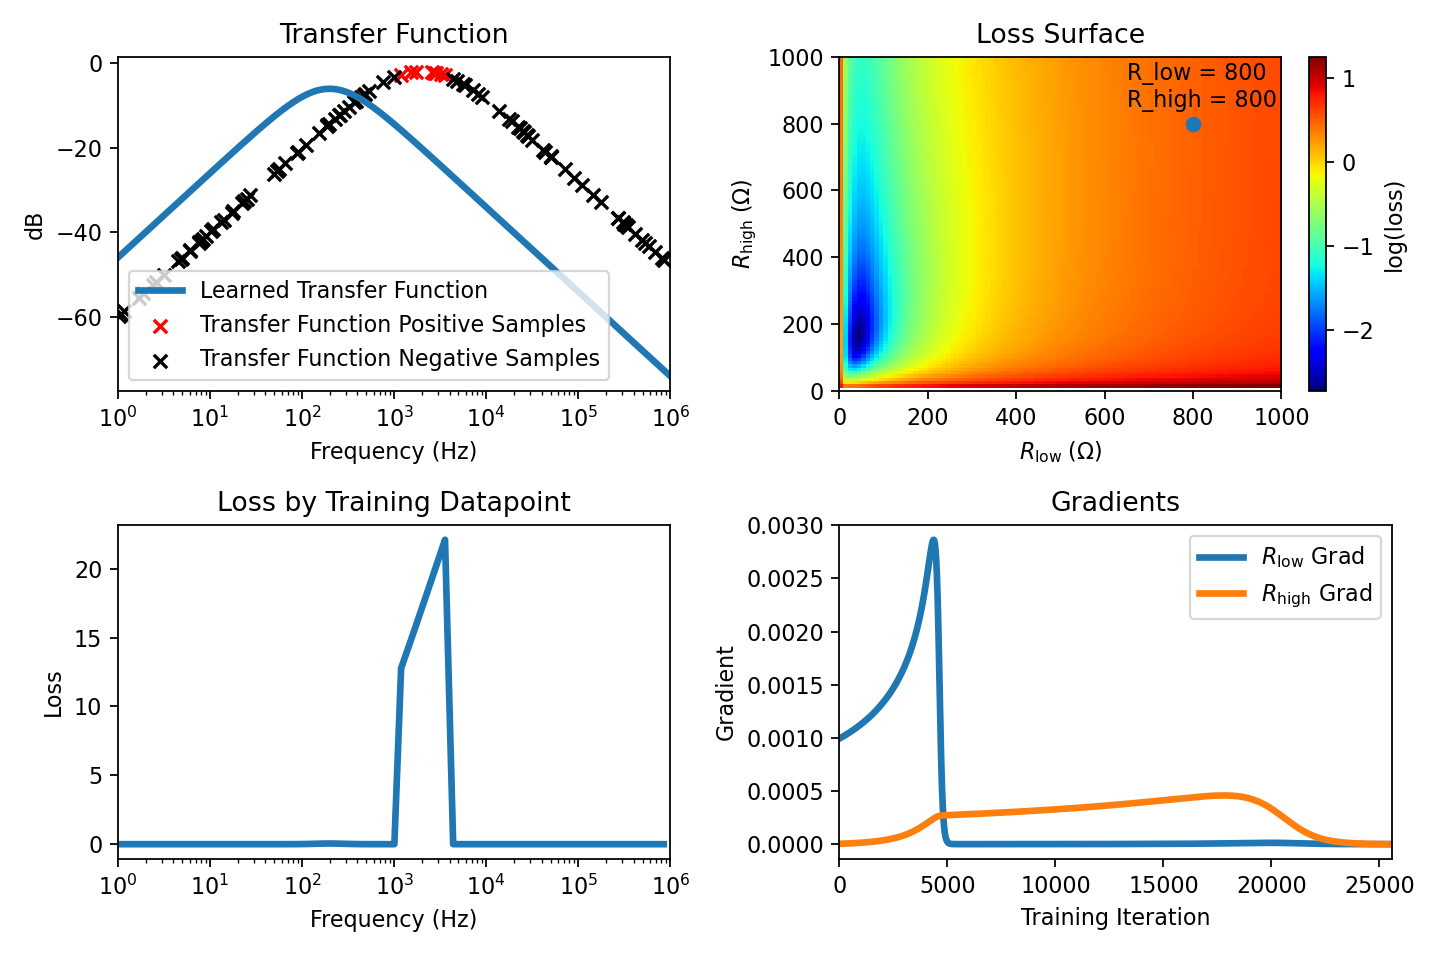

interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=25…

In [46]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_band_bin[1][::subsample] > cutoff_dB
ax1.scatter(train_data_band_bin[0][::subsample][train_data_mask] / (2 * math.pi), train_data_band_bin[1][::subsample][train_data_mask], c="r", marker="x")
ax1.scatter(train_data_band_bin[0][::subsample][~train_data_mask] / (2 * math.pi), train_data_band_bin[1][::subsample][~train_data_mask], c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_circuit(ws, *R_values_band_bin[0]), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Transfer Function", "Transfer Function Positive Samples", "Transfer Function Negative Samples"])

# Show loss surfaces for BCE and MSE Loss
eval_pts = torch.stack(torch.meshgrid((torch.arange(0, 1000, 10), torch.arange(0, 1000, 10)), indexing="ij"))
eval_vals = evaluate_bp_circuit(train_data_band_bin[0][:, None, None], eval_pts[0][None, ...], eval_pts[1][None, ...]) - cutoff_dB
loss_surface = loss_fn(nn.Sigmoid()(eval_vals), (train_data_band_bin[1][..., None, None].expand(eval_vals.shape) > cutoff_dB).float())
loss_surf = ax2.imshow(torch.log(loss_surface.mean(0)).T, cmap=plt.cm.jet, extent=(0, 1000, 0, 1000), aspect="auto", origin="lower")
cur_loss, = ax2.plot(R_values_band_bin[0][0], R_values_band_bin[0][1], marker="o")
cur_loss_label = ax2.annotate(f"R_low = {R_values_band_bin[0][0]:.0f}\nR_high = {R_values_band_bin[0][1]:.0f}", (0, 0), xytext=(0.65, 0.85), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlabel("$R_\mathrm{low} \; (\Omega)$")
ax2.set_ylabel("$R_\mathrm{high} \; (\Omega)$")
fig.colorbar(loss_surf, ax=ax2, label="log(loss)")

# Show loss contributions of each data point
data_loss_mags = loss_surface[::subsample, int(R_values_band_bin[0][0] // 10), int(R_values_band_bin[0][1] // 10)].numpy()
data_order_bin = np.argsort(train_data_band_bin[0][::subsample])
datapoint_loss, = ax3.plot(train_data_band_bin[0][::subsample][data_order_bin] / (2 * math.pi), data_loss_mags[data_order_bin], linewidth=3)
ax3.set_xscale("log")
ax3.set_xlim([1, 1e6])
ax3.set_ylabel("Loss")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Loss by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_band_bin)), grad_values_band_bin, linewidth=3)
cur_grad0, = ax4.plot(0, grad_values_band_bin[0][0], marker="o")
cur_grad1, = ax4.plot(0, grad_values_band_bin[0][1], marker="o")
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_band_bin)])
ax4.legend(["$R_\mathrm{low}$ Grad", "$R_\mathrm{high}$ Grad"])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_band_bin(t=0):
    mags = evaluate_bp_circuit(ws, *R_values_band_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cur_loss.set_data(R_values_band_bin[t][0], R_values_band_bin[t][1])
    cur_loss_label.set_text(f"R_low = {R_values_band_bin[t][0]:.0f}\nR_high = {R_values_band_bin[t][1]:.0f}")
    cur_grad0.set_data(t, grad_values_band_bin[t][0])
    cur_grad1.set_data(t, grad_values_band_bin[t][1])
    data_loss_mags = loss_surface[::subsample, int(R_values_band_bin[t][0] // 10), int(R_values_band_bin[t][1] // 10)].numpy()
    datapoint_loss.set_ydata(data_loss_mags[data_order_bin])
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_band_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_band_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

This circuit converges to the correct values if initialized near the solution (as we did in the above example). But what happens if the initial resistor values are far from the solution? **Try training with initial resistor values of 800 Ohms each. Does the circuit converge within the maximum number of training steps?**

This issue of convergence when the initial resistor values are far from a solution motivates a different loss function. As we can see in the plots above, the loss surface is very flat far from the solution and only a small range of frequencies have an effect on the loss. This observation motivates a loss function that puts more weight on samples near the boundary. **In the code below, replace the loss function with a binary cross entropy loss and retrain using this loss function. How does the loss surface change? What is the rate of convergence as compared to mean squared error loss? Try training starting from multiple initializations (remember that using no arguments to the circuit constructor will yield a random initialization).**

In [44]:
# Create a circuit, use MSE loss with learning rate of 100, batch size 1k and max 100k training steps
lr = 100
circuit = BandPassCircuit(800, 800)
loss_fn = lambda x, y: -(y * torch.log(x) + (1 - y) * torch.log(1 - x))    # BCE loss
train_data_band_bin, R_values_band_bin, grad_values_band_bin = train_bp_circuit_binary(circuit, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Values: R_low = 800, R_high = 800


Training Iter:  26%|████▎            | 25577/100000 [00:55<02:40, 464.69it/s, Loss: 0.065, R_low=39, R_high=160]

Final Resistor Values: R_low = 39, R_high = 160


<IPython.core.display.Javascript object>


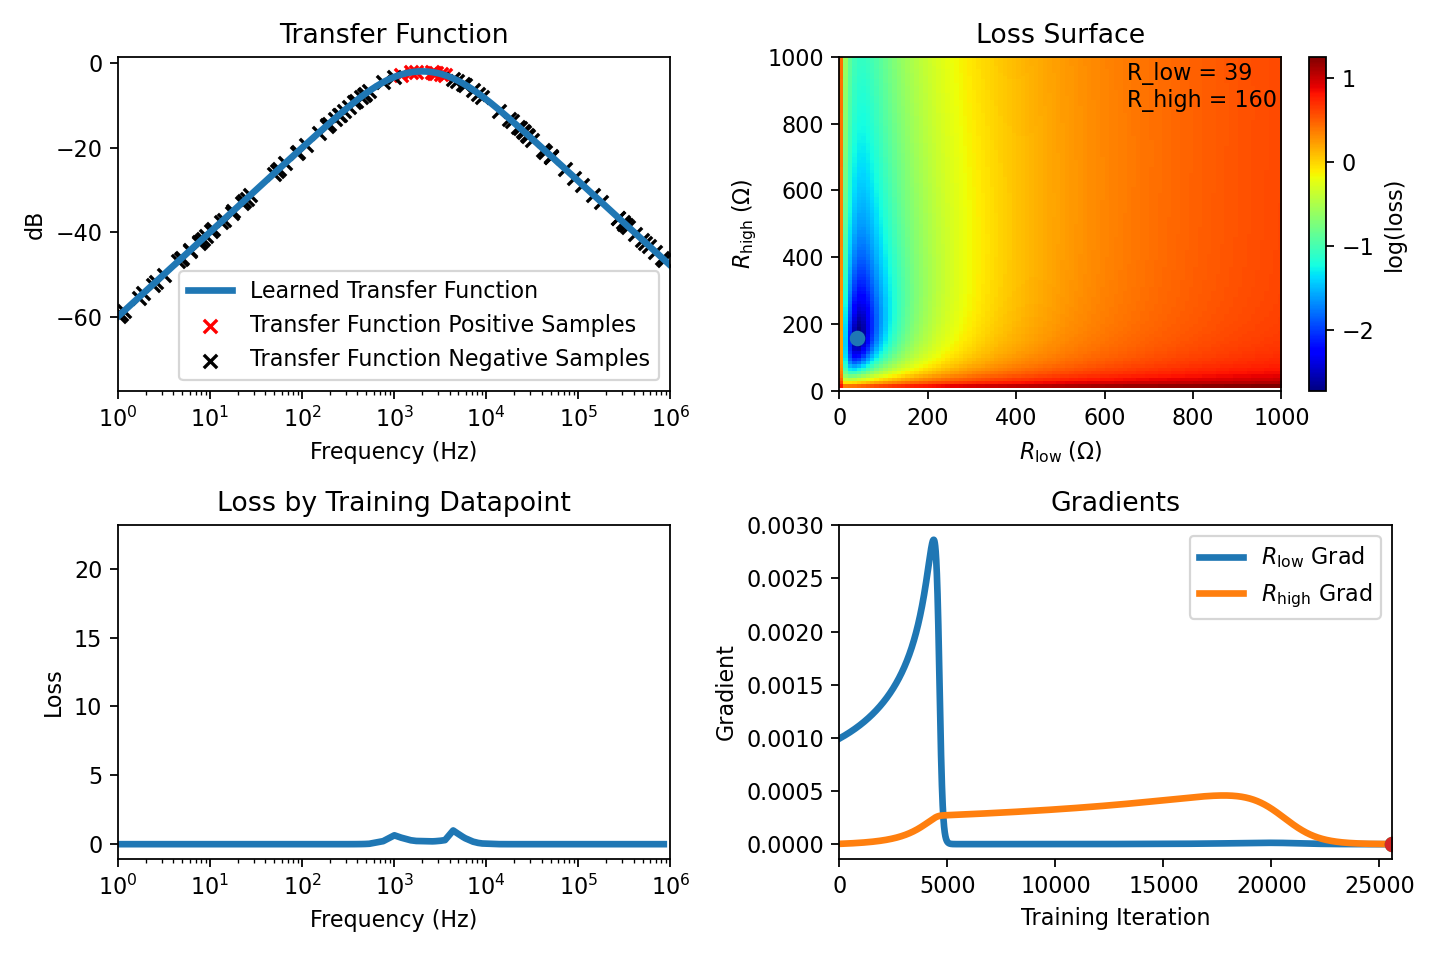

/Users/mjd3/opt/anaconda3/envs/eecs16b/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


interactive(children=(IntSlider(value=0, description='Training Iteration', layout=Layout(width='100%'), max=25…

In [45]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_band_bin[1][::subsample] > cutoff_dB
ax1.scatter(train_data_band_bin[0][::subsample][train_data_mask] / (2 * math.pi), train_data_band_bin[1][::subsample][train_data_mask], c="r", marker="x")
ax1.scatter(train_data_band_bin[0][::subsample][~train_data_mask] / (2 * math.pi), train_data_band_bin[1][::subsample][~train_data_mask], c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_circuit(ws, *R_values_band_bin[0]), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Transfer Function", "Transfer Function Positive Samples", "Transfer Function Negative Samples"])

# Show loss surfaces for BCE and MSE Loss
eval_pts = torch.stack(torch.meshgrid((torch.arange(0, 1000, 10), torch.arange(0, 1000, 10)), indexing="ij"))
eval_vals = evaluate_bp_circuit(train_data_band_bin[0][:, None, None], eval_pts[0][None, ...], eval_pts[1][None, ...]) - cutoff_dB
loss_surface = loss_fn(nn.Sigmoid()(eval_vals), (train_data_band_bin[1][..., None, None].expand(eval_vals.shape) > cutoff_dB).float())
loss_surf = ax2.imshow(torch.log(loss_surface.mean(0)).T, cmap=plt.cm.jet, extent=(0, 1000, 0, 1000), aspect="auto", origin="lower")
cur_loss, = ax2.plot(R_values_band_bin[0][0], R_values_band_bin[0][1], marker="o")
cur_loss_label = ax2.annotate(f"R_low = {R_values_band_bin[0][0]:.0f}\nR_high = {R_values_band_bin[0][1]:.0f}", (0, 0), xytext=(0.65, 0.85), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlabel("$R_\mathrm{low} \; (\Omega)$")
ax2.set_ylabel("$R_\mathrm{high} \; (\Omega)$")
fig.colorbar(loss_surf, ax=ax2, label="log(loss)")

# Show loss contributions of each data point
data_loss_mags = loss_surface[::subsample, int(R_values_band_bin[0][0] // 10), int(R_values_band_bin[0][1] // 10)].numpy()
data_order_bin = np.argsort(train_data_band_bin[0][::subsample])
datapoint_loss, = ax3.plot(train_data_band_bin[0][::subsample][data_order_bin] / (2 * math.pi), data_loss_mags[data_order_bin], linewidth=3)
ax3.set_xscale("log")
ax3.set_xlim([1, 1e6])
ax3.set_ylabel("Loss")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Loss by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_band_bin)), grad_values_band_bin, linewidth=3)
cur_grad0, = ax4.plot(0, grad_values_band_bin[0][0], marker="o")
cur_grad1, = ax4.plot(0, grad_values_band_bin[0][1], marker="o")
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_band_bin)])
ax4.legend(["$R_\mathrm{low}$ Grad", "$R_\mathrm{high}$ Grad"])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_band_bin(t=0):
    mags = evaluate_bp_circuit(ws, *R_values_band_bin[t])
    learned_tf.set_data(ws / (2 * math.pi), mags)
    cur_loss.set_data(R_values_band_bin[t][0], R_values_band_bin[t][1])
    cur_loss_label.set_text(f"R_low = {R_values_band_bin[t][0]:.0f}\nR_high = {R_values_band_bin[t][1]:.0f}")
    cur_grad0.set_data(t, grad_values_band_bin[t][0])
    cur_grad1.set_data(t, grad_values_band_bin[t][1])
    data_loss_mags = loss_surface[::subsample, int(R_values_band_bin[t][0] // 10), int(R_values_band_bin[t][1] // 10)].numpy()
    datapoint_loss.set_ydata(data_loss_mags[data_order_bin])
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_band_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(R_values_band_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Learning Bode Plots from Transfer Function Samples


In [ ]:
def evaluate_bp_bode(freqs, low_cutoff, high_cutoff):
    return -20 * nn.ReLU()(torch.log10(freqs / low_cutoff)) + -20 * nn.ReLU()(torch.log10(high_cutoff / freqs))

# PyTorch model of the band pass bode plot
class BandPassBodePlot(nn.Module):
    def __init__(self, low_cutoff=None, high_cutoff=None):
        super().__init__()
        self.low_cutoff = nn.Parameter(torch.rand(1) * 5000 if low_cutoff is None else torch.tensor(float(low_cutoff)))
        self.high_cutoff = nn.Parameter(torch.rand(1) * 5000 if high_cutoff is None else torch.tensor(float(high_cutoff)))
        
    def forward(self, freqs):
        return evaluate_bp_bode(freqs, self.low_cutoff, self.high_cutoff)

# Train a given band pass bode plot
def train_bp_bode(bode, loss_fn, dataset_size, max_training_steps, lr):
    
    cutoff_values = [[float(bode.low_cutoff.data), float(bode.high_cutoff.data)]]
    grad_values = [[np.nan, np.nan]]
    train_data = generate_bp_training_data(dataset_size)
    print(f"Initial Cutoff Values: f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        
        pred = bode(train_data[0])
        loss = loss_fn(pred, train_data[1]).mean()
        grad = torch.autograd.grad(loss, (bode.low_cutoff, bode.high_cutoff))
        with torch.no_grad():
            bode.low_cutoff -= lr * grad[0]
            bode.high_cutoff -= lr * grad[1]
        
        cutoff_values.append([float(bode.low_cutoff.data), float(bode.high_cutoff.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Cutoff Values: f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
    return train_data, cutoff_values, grad_values

In [ ]:
lr = 1000
bode = BandPassBodePlot()
loss_fn = lambda x, y: (x - y) ** 2    # MSE loss
train_data_band_bode, cutoffs_band_bode, grad_values_band_bode = train_bp_bode(bode, loss_fn, dataset_size, max_training_steps, lr)

In [ ]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_band_bode[1][::subsample] > cutoff_dB
ax1.scatter(train_data_band_bode[0][::subsample][train_data_mask] / (2 * math.pi), train_data_band_bode[1][::subsample][train_data_mask], c="r", marker="x")
ax1.scatter(train_data_band_bode[0][::subsample][~train_data_mask] / (2 * math.pi), train_data_band_bode[1][::subsample][~train_data_mask], c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_bode(ws, *cutoffs_band_bode[0]), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Transfer Function", "Transfer Function Positive Samples", "Transfer Function Negative Samples"])

# Show loss surfaces for BCE and MSE Loss
eval_pts = torch.stack(torch.meshgrid((torch.arange(1, 5001, 50), torch.arange(1, 5001, 50)), indexing="ij"))
eval_vals = evaluate_bp_bode(train_data_band_bode[0][:, None, None], 2 * math.pi * eval_pts[0][None, ...], 2 * math.pi * eval_pts[1][None, ...])
loss_surface = loss_fn(eval_vals, train_data_band_bode[1][..., None, None].expand(eval_vals.shape))
loss_surf = ax2.imshow(torch.log(loss_surface.mean(0)).T, cmap=plt.cm.jet, extent=(1, 5000, 1, 5000), aspect="auto", origin="lower")
cur_loss, = ax2.plot(cutoffs_band_bode[0][0] / (2 * math.pi), cutoffs_band_bode[0][1] / (2 * math.pi), marker="o")
cur_loss_label = ax2.annotate(f"$f_{{c,l}}$ = {cutoffs_band_bode[0][0]:.0f}\n$f_{{c,h}}$ = {cutoffs_band_bode[0][1]:.0f}", (0, 0), xytext=(0.7, 0.82), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlabel("$f_\mathrm{c,low} \; (Hz)$")
ax2.set_ylabel("$f_\mathrm{c,high} \; (Hz)$")
fig.colorbar(loss_surf, ax=ax2, label="log(loss)")

# Show loss contributions of each data point
data_loss_mags = loss_surface[::subsample, int((cutoffs_band_bode[0][0] / (2 * math.pi)) // 50), int((cutoffs_band_bode[0][1] / (2 * math.pi)) // 50)].numpy()
data_order_bode = np.argsort(train_data_band_bode[0][::subsample])
datapoint_loss, = ax3.plot(train_data_band_bode[0][::subsample][data_order_bode] / (2 * math.pi), data_loss_mags[data_order_bode], linewidth=3)
ax3.set_xscale("log")
ax3.set_xlim([1, 1e6])
ax3.set_ylabel("Loss")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Loss by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_band_bode)), grad_values_band_bode, linewidth=3)
cur_grad0, = ax4.plot(0, grad_values_band_bode[0][0], marker="o")
cur_grad1, = ax4.plot(0, grad_values_band_bode[0][1], marker="o")
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_band_bode)])
ax4.legend(["$f_\mathrm{c,l}$ Grad", "$f_\mathrm{c,h}$ Grad"])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_band_bode(t=0):
    learned_tf.set_data(ws / (2 * math.pi), evaluate_bp_bode(ws, *cutoffs_band_bode[t]))
    cur_loss.set_data(cutoffs_band_bode[t][0] / (2 * math.pi), cutoffs_band_bode[t][1] / (2 * math.pi))
    cur_loss_label.set_text(f"$f_{{c,l}}$ = {cutoffs_band_bode[t][0] / (2 * math.pi):.0f}\n$f_{{c,h}}$ = {cutoffs_band_bode[t][1] / (2 * math.pi):.0f}")
    cur_grad0.set_data(t, grad_values_band_bode[t][0])
    cur_grad1.set_data(t, grad_values_band_bode[t][1])
    data_loss_mags = loss_surface[::subsample, int((cutoffs_band_bode[t][0] / (2 * math.pi)) // 50), int((cutoffs_band_bode[t][1] / (2 * math.pi)) // 50)].numpy()
    datapoint_loss.set_ydata(data_loss_mags[data_order_bode])
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_band_bode, 
                 t=widgets.IntSlider(value=0, min=0, max=len(cutoffs_band_bode) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Learning Bode Plots from Binary Data

In [ ]:
# Train a given band pass bode plot
def train_bp_bode_bin(bode, loss_fn, dataset_size, max_training_steps, lr):
    
    cutoff_values = [[float(bode.low_cutoff.data), float(bode.high_cutoff.data)]]
    grad_values = [[np.nan, np.nan]]
    train_data = generate_bp_training_data(dataset_size)
    print(f"Initial Cutoff Values: f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        
        pred = nn.Sigmoid()(bode(train_data[0]))
        loss = loss_fn(pred, (train_data[1] > cutoff_dB).float()).mean()
        grad = torch.autograd.grad(loss, (bode.low_cutoff, bode.high_cutoff))
        with torch.no_grad():
            bode.low_cutoff -= lr * grad[0]
            bode.high_cutoff -= lr * grad[1]
        
        cutoff_values.append([float(bode.low_cutoff.data), float(bode.high_cutoff.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Cutoff Values: f_c,l = {float(bode.low_cutoff.data / (2 * math.pi)):.0f} Hz, f_c,h = {float(bode.high_cutoff.data / (2 * math.pi)):.0f} Hz")
    return train_data, cutoff_values, grad_values

In [ ]:
lr = 1e5
bode_bin = BandPassBodePlot()
loss_fn = lambda x, y: -(y * torch.log(x) + (1 - y) * torch.log(1 - x))    # BCE loss
train_data_band_bode_bin, cutoffs_band_bode_bin, grad_values_band_bode_bin = train_bp_bode_bin(bode_bin, loss_fn, dataset_size, max_training_steps, lr)

In [ ]:
# Plot transfer function over training
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
ws = 2 * math.pi * 10 ** torch.linspace(0, 6, 1000)
subsample = int(dataset_size / 100)
train_data_mask = train_data_band_bode_bin[1][::subsample] > cutoff_dB
ax1.scatter(train_data_band_bode_bin[0][::subsample][train_data_mask] / (2 * math.pi), train_data_band_bode_bin[1][::subsample][train_data_mask], c="r", marker="x")
ax1.scatter(train_data_band_bode_bin[0][::subsample][~train_data_mask] / (2 * math.pi), train_data_band_bode_bin[1][::subsample][~train_data_mask], c="k", marker="x")
learned_tf, = ax1.semilogx(ws / (2 * math.pi), evaluate_bp_bode(ws, *cutoffs_band_bode_bin[0]), linewidth=3)
ax1.set_xlim([1, 1e6])
ax1.set_title("Transfer Function")
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("dB")
ax1.legend(["Learned Transfer Function", "Transfer Function Positive Samples", "Transfer Function Negative Samples"])

# Show loss surfaces for BCE and MSE Loss
eval_pts = torch.stack(torch.meshgrid((torch.arange(1, 5001, 50), torch.arange(1, 5001, 50)), indexing="ij"))
eval_vals = evaluate_bp_bode(train_data_band_bode_bin[0][:, None, None], 2 * math.pi * eval_pts[0][None, ...], 2 * math.pi * eval_pts[1][None, ...])
loss_surface = loss_fn(nn.Sigmoid()(eval_vals), (train_data_band_bode_bin[1][..., None, None].expand(eval_vals.shape) > cutoff_dB).float())
loss_surf = ax2.imshow(torch.log(loss_surface.mean(0)).T, cmap=plt.cm.jet, extent=(1, 5000, 1, 5000), aspect="auto", origin="lower")
cur_loss, = ax2.plot(cutoffs_band_bode_bin[0][0] / (2 * math.pi), cutoffs_band_bode_bin[0][1] / (2 * math.pi), marker="o")
cur_loss_label = ax2.annotate(f"$f_{{c,l}}$ = {cutoffs_band_bode_bin[0][0]:.0f}\n$f_{{c,h}}$ = {cutoffs_band_bode_bin[0][1]:.0f}", (0, 0), xytext=(0.7, 0.82), textcoords='axes fraction')
ax2.set_title("Loss Surface")
ax2.set_xlabel("$f_\mathrm{c,low} \; (Hz)$")
ax2.set_ylabel("$f_\mathrm{c,high} \; (Hz)$")
fig.colorbar(loss_surf, ax=ax2, label="log(loss)")

# Show loss contributions of each data point
data_loss_mags = loss_surface[::subsample, int((cutoffs_band_bode_bin[0][0] / (2 * math.pi)) // 50), int((cutoffs_band_bode_bin[0][1] / (2 * math.pi)) // 50)].numpy()
data_order_bode_bin = np.argsort(train_data_band_bode_bin[0][::subsample])
datapoint_loss, = ax3.plot(train_data_band_bode_bin[0][::subsample][data_order_bode_bin] / (2 * math.pi), data_loss_mags[data_order_bode_bin], linewidth=3)
ax3.set_xscale("log")
ax3.set_xlim([1, 1e6])
ax3.set_ylabel("Loss")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_title("Loss by Training Datapoint")

# Show gradient at each training iteration
ax4.plot(np.arange(len(grad_values_band_bode_bin)), grad_values_band_bode_bin, linewidth=3)
cur_grad0, = ax4.plot(0, grad_values_band_bode_bin[0][0], marker="o")
cur_grad1, = ax4.plot(0, grad_values_band_bode_bin[0][1], marker="o")
ax4.set_xlabel("Training Iteration")
ax4.set_ylabel("Gradient")
ax4.set_title("Gradients")
ax4.set_xlim([-1, len(grad_values_band_bode_bin)])
ax4.legend(["$f_\mathrm{c,l}$ Grad", "$f_\mathrm{c,h}$ Grad"])

plt.tight_layout()

# Main update function for interactive plots
def update_iter_band_bode_bin(t=0):
    learned_tf.set_data(ws / (2 * math.pi), evaluate_bp_bode(ws, *cutoffs_band_bode_bin[t]))
    cur_loss.set_data(cutoffs_band_bode_bin[t][0] / (2 * math.pi), cutoffs_band_bode_bin[t][1] / (2 * math.pi))
    cur_loss_label.set_text(f"$f_{{c,l}}$ = {cutoffs_band_bode_bin[t][0] / (2 * math.pi):.0f}\n$f_{{c,h}}$ = {cutoffs_band_bode_bin[t][1] / (2 * math.pi):.0f}")
    cur_grad0.set_data(t, grad_values_band_bode_bin[t][0])
    cur_grad1.set_data(t, grad_values_band_bode_bin[t][1])
    data_loss_mags = loss_surface[::subsample, int((cutoffs_band_bode_bin[t][0] / (2 * math.pi)) // 50), int((cutoffs_band_bode_bin[t][1] / (2 * math.pi)) // 50)].numpy()
    datapoint_loss.set_ydata(data_loss_mags[data_order_bode_bin])
    fig.canvas.draw_idle()
    
# Include sliders for relevant quantities
ip = interactive(update_iter_band_bode_bin, 
                 t=widgets.IntSlider(value=0, min=0, max=len(cutoffs_band_bode_bin) - 1, step=1, description="Training Iteration", style={'description_width': 'initial'}, layout=Layout(width='100%')))
ip

## Learn a Color Organ Circuit
Let's put all of these together to try and learn a color organ circuit from a low pass, high pass, and band pass circuits.

In [35]:
# PyTorch model of the color organ circuit
class ColorOrganCircuit(nn.Module):
    def __init__(self, R_low=None, R_high=None, R_band_low=None, R_band_high=None):
        super().__init__()
        self.low = LowPassCircuit(R_low)
        self.high = HighPassCircuit(R_high)
        self.band = BandPassCircuit(R_band_low, R_band_high)
        
    def forward(self, freqs):
        return torch.stack((self.low(freqs), self.band(freqs), self.high(freqs)))
    
    
# Generate training data in a uniform log scale of frequences, then evaluate using the true transfer function
R_low_des = 1 / (2 * math.pi * 800 * cap_value)
R_band_low_des = 1 / (2 * math.pi * 4000 * cap_value)
R_band_high_des = 1 / (2 * math.pi * 1000 * cap_value)
R_high_des = 1 / (2 * math.pi * 5000 * cap_value)
def generate_co_training_data(n):
    rand_ws = 2 * math.pi * torch.pow(10, torch.rand(n) * 6)
    labels = torch.stack((evaluate_lp_circuit(rand_ws, R_low_des), evaluate_bp_circuit(rand_ws, R_band_low_des, R_band_high_des), evaluate_hp_circuit(rand_ws, R_high_des)))
    return rand_ws, labels

# Train a given color organ circuit
def train_co_circuit(circuit, loss_fn, dataset_size, max_training_steps, lr):
    
    R_values = [[float(circuit.low.R.data), float(circuit.band.R_low.data), float(circuit.band.R_high.data), float(circuit.high.R.data)]]
    grad_values = [[np.nan, np.nan, np.nan, np.nan]]
    train_data = generate_co_training_data(dataset_size)
    print(f"Initial Resistor Values: {float(circuit.low.R.data):.0f}, {float(circuit.band.R_low.data):.0f}, {float(circuit.band.R_high.data):.0f}, {float(circuit.high.R.data):.0f}")
    
    iter_bar = tqdm.trange(max_training_steps, desc="Training Iter")
    for i in iter_bar:
        pred = nn.Sigmoid()(circuit(train_data[0]) - cutoff_dB)
        loss = loss_fn(pred, (train_data[1] > cutoff_dB).float()).mean()
        grad = torch.autograd.grad(loss, (circuit.low.R, circuit.band.R_low, circuit.band.R_high, circuit.high.R))
        with torch.no_grad():
            circuit.low.R -= lr * grad[0]
            circuit.band.R_low -= lr * grad[1]
            circuit.band.R_high -= lr * grad[2]
            circuit.high.R -= lr * grad[3]
            
        R_values.append([float(circuit.low.R.data), float(circuit.band.R_low.data), float(circuit.band.R_high.data), float(circuit.high.R.data)])
        grad_values.append([float(grad[0].data), float(grad[1].data), float(grad[2].data), float(grad[3].data)])
        iter_bar.set_postfix_str(f"Loss: {float(loss.data):.3f}, Rs = {float(circuit.low.R.data):.0f}, {float(circuit.band.R_low.data):.0f}, {float(circuit.band.R_high.data):.0f}, {float(circuit.high.R.data):.0f}")
        if loss.data < 1e-6 or (abs(grad[0].data) < 1e-6 and abs(grad[1].data) < 1e-6):
            break

    print(f"Final Resistor Values: {float(circuit.low.R.data):.0f}, {float(circuit.band.R_low.data):.0f}, {float(circuit.band.R_high.data):.0f}, {float(circuit.high.R.data):.0f}")
    return train_data, R_values, grad_values

In [36]:
lr = 100
dataset_size = 10000
max_training_steps = 100000
co = ColorOrganCircuit()
loss_fn = lambda x, y: -(y * torch.log(x) + (1 - y) * torch.log(1 - x))    # BCE loss
train_data_co, R_values_co, grad_values_co = train_co_circuit(co, loss_fn, dataset_size, max_training_steps, lr)

Initial Resistor Values: 260, 508, 104, 706


Training Iter:  20%|███            | 20042/100000 [01:02<04:09, 321.05it/s, Loss: 0.207, Rs = 204, 40, 160, 462]


Final Resistor Values: 204, 40, 160, 462


## Visualizing the computation graph for the Color Organ

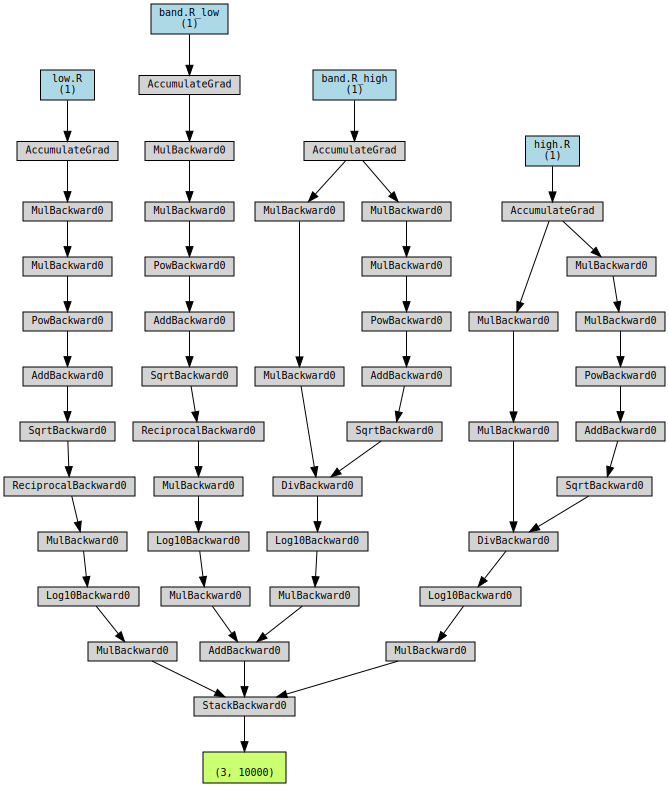

In [41]:
from torchviz import make_dot
make_dot(co(generate_co_training_data(dataset_size)[0]), params=dict(co.named_parameters()))